In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.spatial import distance
import xml.etree.ElementTree as ET
from shapely.geometry import Polygon, LineString
import pandas as pd
#from src.generate_traffic_data import clean_carla, spawn_scene, run_scene
import carla
import os
os.getcwd()
from datetime import datetime
import time
import random
from tqdm import tqdm
import networkx as nx
import numpy as np
import pickle
from graph_creator.MapGraph import MapGraph
from graph_creator.utilities import make_node_edge_df
from graph_creator.SubgraphIsomorphismChecker import IsomorphicGrapCoverageCounter
from graph_creator.ActorGraph import ActorType

os.chdir('../..')
print(os.getcwd())

#from graph_creator.MapGraph import MapGraph
#from graph_creator.ActorGraph import ActorGraph

from graph_creator.plot_graphs import plot_lane_map_advanced, add_actors_to_map, add_actor_edges_to_map

from glob import glob
import pickle
import networkx as nx
import random
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

graph_paths = glob("/home/tmuehlen/repos/graph_coverage/actor_graphs/carla_w_intersection/*pkl")
len(graph_paths)

/home/tmuehlen/repos/graph_coverage


14099

### Start comparing graphs by randomly picking some:

In [3]:
# Define a random set of coverage situations with 3 nodes each
# This still needs to be replaced by more strategically selected graphs

#idxs = [100, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
idxs = random.sample(list(range(len(graph_paths))), 10)

coverage_graphs = {}
cov_data = {}

for idx in idxs:
    graph_path = graph_paths[idx]
    with open(graph_path, "rb") as file:
        ag_nx = pickle.load(file)
    #random.sample(ag_nx.nodes, 3)
    if ag_nx.number_of_nodes() > 2:
        coverage_graphs[idx] = ag_nx.subgraph(random.sample(list(ag_nx.nodes), 3))
        cov_data[idx] = []

cov_data["degree"] = []
cov_data["density"] = []
cov_data["diameter"] = []


In [4]:
isom_cov_counter = IsomorphicGrapCoverageCounter(coverage_graphs, graph_paths[:100], node_match = ["actor_type", "lane_change", "is_on_intersection"], edge_match = ["edge_type"])
isom_cov_counter.count_isomorphic_graphs()
cov_data_df = isom_cov_counter.cov_data_df

100%|██████████| 100/100 [00:00<00:00, 387.49it/s]


In [5]:
cov_data_df.head(2)

,3868,9449,11439,5108,4461,9168,degree,density,diameter
0,False,False,False,False,False,False,2.0,1.0,1
1,False,False,False,False,False,False,2.0,1.0,1


In [6]:
cov_data_df.mean()
cov_data_df.shape[1] - 3

6

In [7]:
cov_data_df.groupby(list(cov_data_df.columns[:(cov_data_df.shape[1] - 3)]), as_index=False).size()


,3868,9449,11439,5108,4461,9168,size
0,False,False,False,False,False,False,67
1,False,True,False,False,False,False,3
2,True,False,True,True,True,True,23
3,True,True,True,True,True,True,7


In [8]:
# sns.pairplot(data=cov_data_df)
# plt.show()


### define some situations manually

In [9]:
coverage_graphs = {}

In [10]:
G = nx.MultiDiGraph()
G.add_node("a", actor_type=ActorType.VEHICLE, lane_change=False, is_on_intersection=False)
G.add_node("b", actor_type=ActorType.VEHICLE, lane_change=False, is_on_intersection=False)
G.add_node("c", actor_type=ActorType.VEHICLE, lane_change=False, is_on_intersection=False)
G.add_edge("a", "b", edge_type="following_lead")
G.add_edge("b", "a", edge_type="following_lead")
G.add_edge("a", "c", edge_type="neighbor_vehicle")
G.add_edge("c", "a", edge_type="neighbor_vehicle")
G.edges(data=True)
coverage_graphs["lead_vehicle_in_front_with_neighbor_vehicle"] = G

In [11]:
G = nx.MultiDiGraph()
G.add_node("a", actor_type=ActorType.VEHICLE, lane_change=False, is_on_intersection=False)
G.add_node("b", actor_type=ActorType.VEHICLE, lane_change=False, is_on_intersection=False)
G.add_node("c", actor_type=ActorType.VEHICLE, lane_change=False, is_on_intersection=False)
G.add_edge("a", "b", edge_type="following_lead")
G.add_edge("b", "a", edge_type="following_lead")
G.add_edge("a", "c", edge_type="following_lead")
G.add_edge("c", "a", edge_type="following_lead")
G.edges(data=True)
coverage_graphs["lead_vehicle_in_front_following_vehicle_in_the_back"] = G

In [12]:
G = nx.MultiDiGraph()
G.add_node("a", actor_type=ActorType.VEHICLE, lane_change=False, is_on_intersection=False)
G.add_node("b", actor_type=ActorType.VEHICLE, lane_change=False, is_on_intersection=False)
G.add_node("c", actor_type=ActorType.VEHICLE, lane_change=True, is_on_intersection=False)
G.add_edge("a", "b", edge_type="following_lead")
G.add_edge("b", "a", edge_type="following_lead")
G.add_edge("a", "c", edge_type="following_lead")
G.add_edge("c", "a", edge_type="following_lead")
G.edges(data=True)
coverage_graphs["cut_in"] = G

In [13]:
G = nx.MultiDiGraph()
G.add_node("a", actor_type=ActorType.VEHICLE, lane_change=False, is_on_intersection=False)
G.add_node("b", actor_type=ActorType.VEHICLE, lane_change=False, is_on_intersection=False)
G.add_node("c", actor_type=ActorType.VEHICLE, lane_change=False, is_on_intersection=False)
G.add_edge("a", "b", edge_type="following_lead")
G.add_edge("b", "a", edge_type="following_lead")
G.add_edge("a", "c", edge_type="op")
G.add_edge("c", "a", edge_type="neighbor_vehicle")
G.edges(data=True)
# hm, this actually could also be that a vehicle was 2 lanes or more away...
coverage_graphs["cut_out"] = G

In [14]:
coverage_graphs

{'lead_vehicle_in_front_with_neighbor_vehicle': <networkx.classes.multidigraph.MultiDiGraph at 0x7e46eca47430>,
 'lead_vehicle_in_front_following_vehicle_in_the_back': <networkx.classes.multidigraph.MultiDiGraph at 0x7e46eca46890>,
 'cut_in': <networkx.classes.multidigraph.MultiDiGraph at 0x7e46eca46200>,
 'cut_out': <networkx.classes.multidigraph.MultiDiGraph at 0x7e46eca47f40>}

In [15]:
len(graph_paths)


14099

In [16]:
isom_cov_counter = IsomorphicGrapCoverageCounter(coverage_graphs, graph_paths[:1000], node_match = ["actor_type", "lane_change", "is_on_intersection"], edge_match = ["edge_type"])
isom_cov_counter.count_isomorphic_graphs()
cov_data_df = isom_cov_counter.cov_data_df

100%|██████████| 1000/1000 [00:01<00:00, 520.39it/s]


In [17]:
cov_data_df.head(2)

,lead_vehicle_in_front_with_neighbor_vehicle,lead_vehicle_in_front_following_vehicle_in_the_back,cut_in,cut_out,degree,density,diameter
0,False,False,False,False,2.0,1.0,1
1,False,False,False,False,2.0,1.0,1


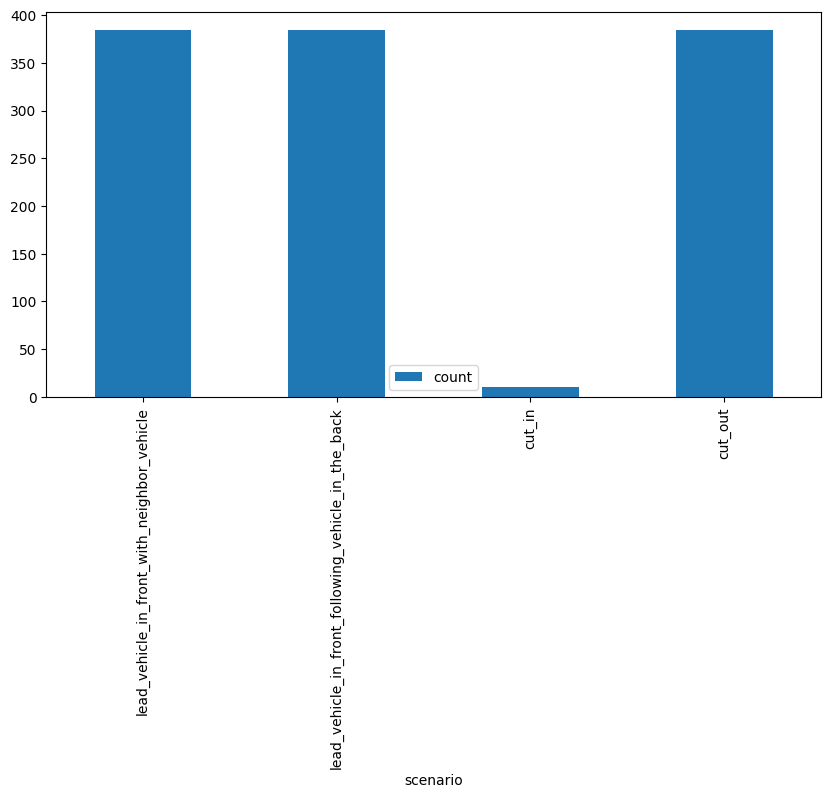

In [18]:
barchart_df = cov_data_df[coverage_graphs.keys()].sum().reset_index().rename(columns={"index":"scenario", 0: "count"})
barchart_df.plot(kind="bar", x="scenario", y="count", figsize=(10, 5))
plt.savefig('article/plots/subgraph_isomorphism_carla_coverage_barchart.png', dpi=300, bbox_inches='tight')

plt.show()


In [19]:
columns = list(coverage_graphs.keys())
# cov_data_df[coverage_graphs.keys()]
n_cols = len(columns)
agreement_matrix = np.zeros((n_cols, n_cols))

for i, col1 in enumerate(columns):
    for j, col2 in enumerate(columns):
        if i == j:
            # Diagonal: 100% agreement with itself
            agreement_matrix[i, j] = 100
        else:
            # Calculate percentage of rows where both columns agree
            agreement = (cov_data_df[col1] == cov_data_df[col2]).sum() / len(cov_data_df) * 100
            agreement_matrix[i, j] = agreement

# Create DataFrame for the heatmap
agreement_df = pd.DataFrame(
    agreement_matrix,
    index=columns,
    columns=columns
)
agreement_df

,lead_vehicle_in_front_with_neighbor_vehicle,lead_vehicle_in_front_following_vehicle_in_the_back,cut_in,cut_out
lead_vehicle_in_front_with_neighbor_vehicle,100.0,100.0,62.0,100.0
lead_vehicle_in_front_following_vehicle_in_the_back,100.0,100.0,62.0,100.0
cut_in,62.0,62.0,100.0,62.0
cut_out,100.0,100.0,62.0,100.0


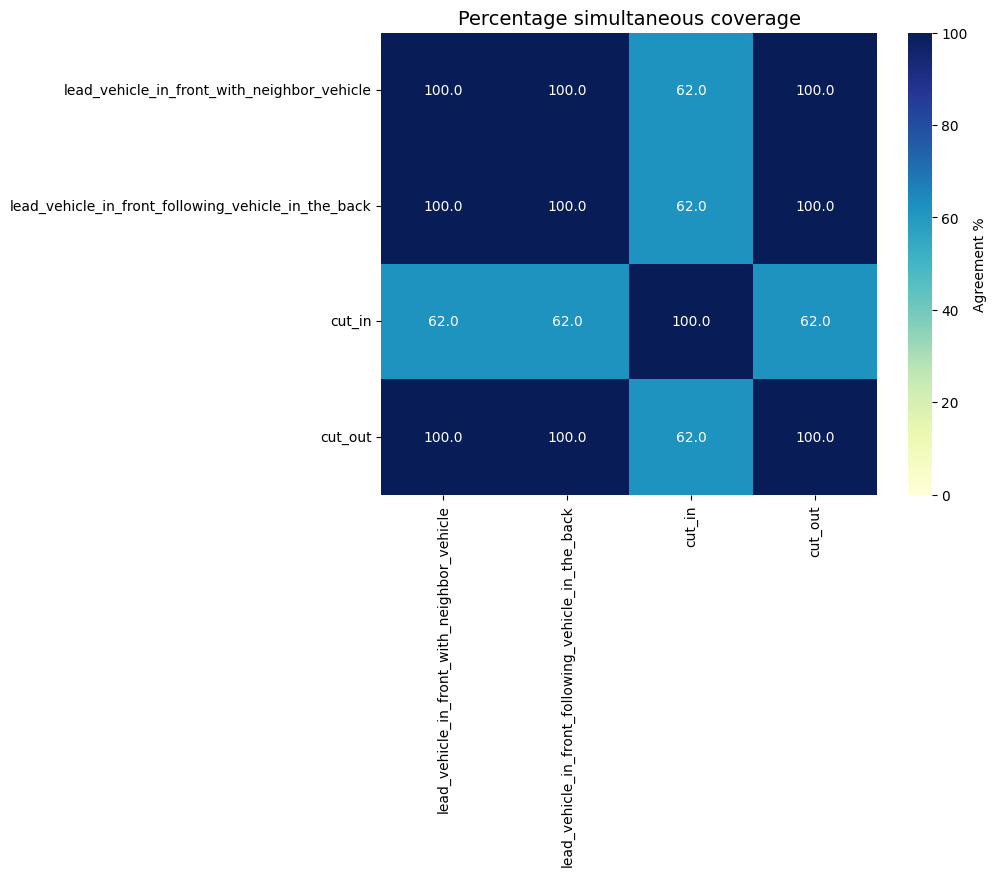

In [20]:
# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(agreement_df, 
            annot=True,  # Show percentages in cells
            fmt='.1f',   # Format to 1 decimal place
            cmap='YlGnBu',  # Color scheme
            vmin=0, 
            vmax=100,
            cbar_kws={'label': 'Agreement %'})
plt.title('Percentage simultaneous coverage', fontsize=14)
#plt.tight_layout()
plt.savefig('article/plots/subgraph_isomorphism_agreement_matrix_manual_scenarios_carla.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
os.getcwd()

In [ ]:
groupby_df = cov_data_df.groupby(list(cov_data_df.columns[:(len(coverage_graphs.keys()))]), as_index=False).size()
groupby_df.columns = groupby_df.columns.str.replace('_', ' ')
latex_table = groupby_df.to_latex(index=False, caption='My Table', 
                          label='tab:mytable', position='htbp')

print(latex_table)

\begin{table}[htbp]
\caption{My Table}
\label{tab:mytable}
\begin{tabular}{rrrrr}
\toprule
lead vehicle in front with neighbor vehicle & lead vehicle in front following vehicle in the back & cut in & cut out & size \\
\midrule
False & False & False & False & 613 \\
False & False & True & False & 3 \\
True & True & False & True & 377 \\
True & True & True & True & 7 \\
\bottomrule
\end{tabular}
\end{table}



In [35]:
coverage_graph_names = list(coverage_graphs.keys())

cov_data_df[cov_data_df[coverage_graph_names[0]]]

,lead_vehicle_in_front_with_neighbor_vehicle,lead_vehicle_in_front_following_vehicle_in_the_back,cut_in,cut_out,degree,density,diameter
3,True,True,False,True,2.666667,0.666667,2
5,True,True,False,True,2.666667,0.666667,2
6,True,True,False,True,3.333333,0.333333,4
7,True,True,False,True,2.666667,0.666667,2
12,True,True,False,True,6.222222,0.388889,3
...,...,...,...,...,...,...,...
986,True,True,False,True,2.666667,0.666667,2
988,True,True,False,True,4.000000,0.666667,2
994,True,True,False,True,4.571429,0.380952,4
998,True,True,False,True,3.333333,0.333333,4


# Notebook junkyard